# Face Generation

Jay Urbain  
jay.urbain@gmail.com

In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

floyd run --gpu --data R5KrjnANiKVhLWAkpXhNBe --mode jupyter env=tensorflow-1.0

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

['/input/mnist/image_13119.jpg', '/input/mnist/image_32703.jpg', '/input/mnist/image_26142.jpg', '/input/mnist/image_58756.jpg', '/input/mnist/image_42180.jpg', '/input/mnist/image_21138.jpg', '/input/mnist/image_34161.jpg', '/input/mnist/image_9501.jpg', '/input/mnist/image_40722.jpg', '/input/mnist/image_18123.jpg', '/input/mnist/image_20409.jpg', '/input/mnist/image_33432.jpg', '/input/mnist/image_59485.jpg', '/input/mnist/image_5226.jpg', '/input/mnist/image_41451.jpg', '/input/mnist/image_25413.jpg', '/input/mnist/image_13830.jpg', '/input/mnist/image_52305.jpg', '/input/mnist/image_39883.jpg', '/input/mnist/image_1662.jpg', '/input/mnist/image_10284.jpg', '/input/mnist/image_42898.jpg', '/input/mnist/image_34879.jpg', '/input/mnist/image_53034.jpg', '/input/mnist/image_2391.jpg']


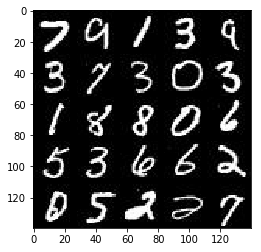

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
print(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images])
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

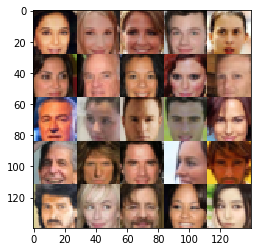

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))  
    Z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=(None))
    return input_images, Z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function 
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):

        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * x1, x1)
         # 14x14x64
            
        # layer 2
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='SAME',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # layer 3
        x3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='SAME',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
         # 4x4x256
            
        # flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # Fully connected input layer connected
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x256
        
        # Convolution transpose layers
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x64
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 3, strides=1, padding='SAME',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model                
    _, image_width, image_height, image_channels = data_shape
    
    # model_inputs: input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # model_loss: d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # model_opt: d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Batch counter
    batch_count = 0
    
    # Number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 26.4727
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 3.4700
Epoch 1/2... Discriminator Loss: 1.8784... Generator Loss: 4.8234
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 3.0913
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.6902
Epoch 1/2... Discriminator Loss: 2.5664... Generator Loss: 0.1694
Epoch 1/2... Discriminator Loss: 1.7956... Generator Loss: 0.4363
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.5097
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.9967
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 1.6357


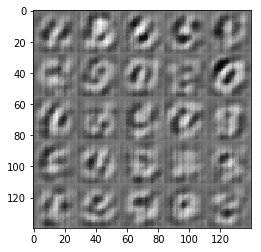

Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.9787
Epoch 1/2... Discriminator Loss: 1.5861... Generator Loss: 0.4218
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 1.7485... Generator Loss: 0.3548
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.4153
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.9095
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.8595


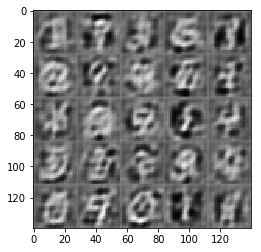

Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.6438... Generator Loss: 0.4076
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 1.4457
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 1.5027
Epoch 1/2... Discriminator Loss: 1.6303... Generator Loss: 2.2857
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 1.0978
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.7959


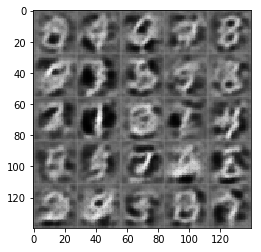

Epoch 1/2... Discriminator Loss: 1.7270... Generator Loss: 0.3641
Epoch 1/2... Discriminator Loss: 1.5705... Generator Loss: 0.5517
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.5220
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.3034
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.7192


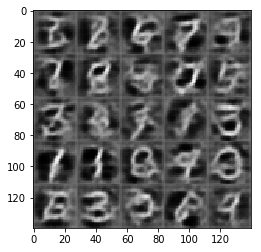

Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 1.1047
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.6532
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.5382
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 0.8301


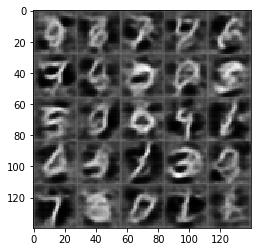

Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 1.4815
Epoch 1/2... Discriminator Loss: 1.7784... Generator Loss: 2.1601
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.6384


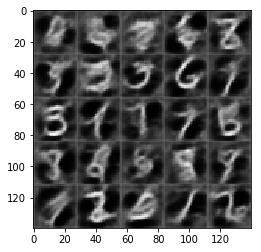

Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 1.4105
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.9280
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 1.7076
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.8899
Epoch 1/2... Discriminator Loss: 1.2031... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.7266
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.0921
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.0398


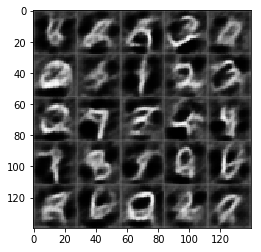

Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 1.1223
Epoch 1/2... Discriminator Loss: 1.5937... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.5416
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.2688
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 1.0789


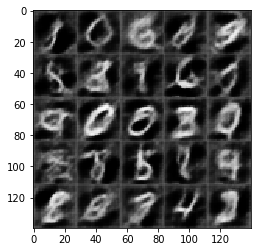

Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.1570
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 1.0142
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 1.5758
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 2.2417
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 1.0388
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.7621


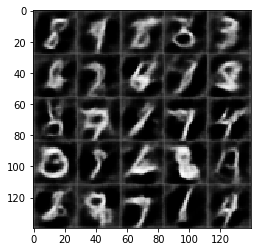

Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 1.1624
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 1.6276
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.0731
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.6591
Epoch 1/2... Discriminator Loss: 1.5451... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.8112


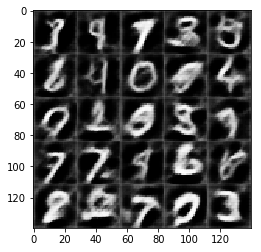

Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 1.2921... Generator Loss: 1.1477
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 0.5029
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.3519


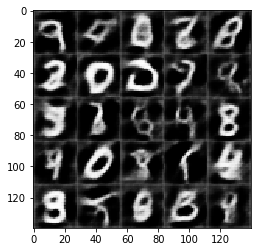

Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 0.5375
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 1.9573
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 1.2319... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.5731
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.6245
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.7126


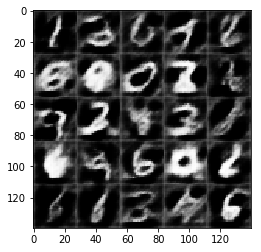

Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 0.9573... Generator Loss: 1.2968
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 0.9368
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 1.7941
Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.4265
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.5295


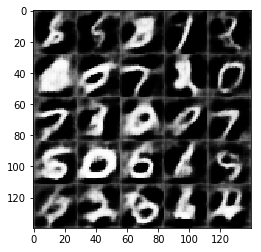

Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 1.6012... Generator Loss: 0.3868
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 1.5596... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 1.6220


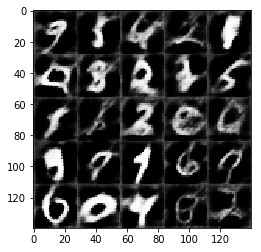

Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 1.5538
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 1.3143
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.4813
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.4624


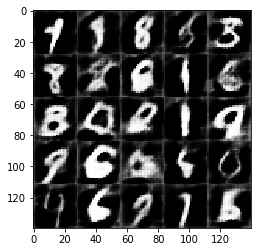

Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 2.0351
Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.7550
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.7687
Epoch 1/2... Discriminator Loss: 0.8726... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 2.5928
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.0657


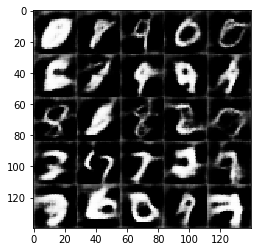

Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.5174
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 1.0445
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.9722
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.7465
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 0.4871


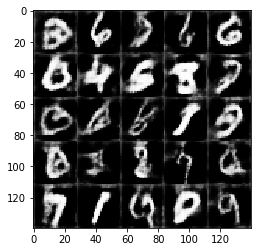

Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.3676
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.4690
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.6842
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.7227
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 1.1882
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.1751


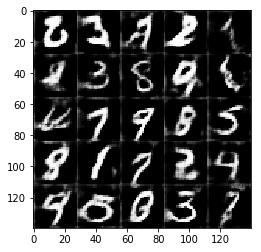

Epoch 1/2... Discriminator Loss: 1.7326... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.7149
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.2758
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.5640
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 1.2833
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 1.5455


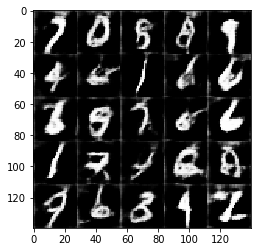

Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.6190
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.2518
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.1330
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.2429
Epoch 2/2... Discriminator Loss: 2.3615... Generator Loss: 0.2166
Epoch 2/2... Discriminator Loss: 1.7212... Generator Loss: 0.4369
Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.1290


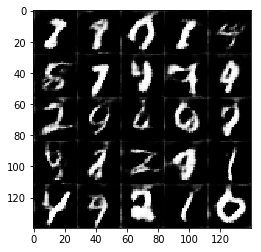

Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.6256
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.0505
Epoch 2/2... Discriminator Loss: 1.6393... Generator Loss: 0.3851
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 1.0762
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.8577
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 1.9508
Epoch 2/2... Discriminator Loss: 1.4730... Generator Loss: 0.4749


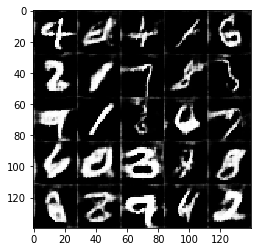

Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 2.8226
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.4387
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 1.2051
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.5512
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.6393... Generator Loss: 0.4393
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.4828


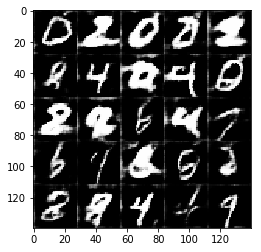

Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.9091
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.1778
Epoch 2/2... Discriminator Loss: 1.8060... Generator Loss: 0.3893
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.6879
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 2.1359
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.6105
Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 1.3857
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.1872


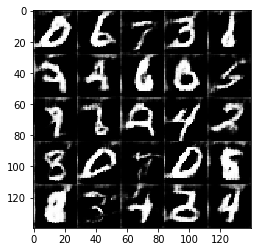

Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 1.3951
Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 2.8875
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.6862
Epoch 2/2... Discriminator Loss: 2.3078... Generator Loss: 0.2751
Epoch 2/2... Discriminator Loss: 1.8411... Generator Loss: 0.3192


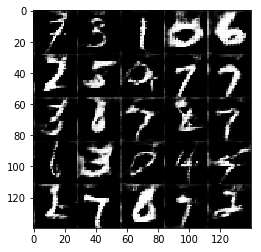

Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 2.0120
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.9444
Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 0.9238
Epoch 2/2... Discriminator Loss: 1.5510... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 1.7637... Generator Loss: 0.3591
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 2.2476


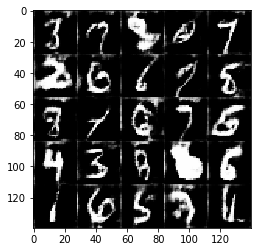

Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 1.1661
Epoch 2/2... Discriminator Loss: 1.6066... Generator Loss: 0.4480
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 1.3728
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.0987
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.7139
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 0.9508


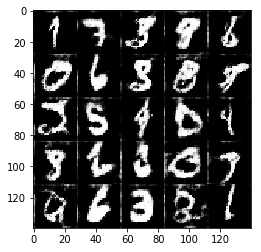

Epoch 2/2... Discriminator Loss: 0.7680... Generator Loss: 1.5685
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.7536
Epoch 2/2... Discriminator Loss: 1.6428... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 2.6339
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 1.9748
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 0.9379
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 1.9185


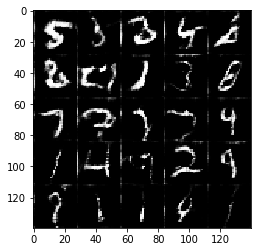

Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 2.0962
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 1.5384
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.5621
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 2.6921
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 0.7195... Generator Loss: 1.5410
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 2.5740


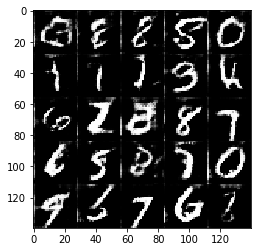

Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.6942
Epoch 2/2... Discriminator Loss: 0.6898... Generator Loss: 1.6393
Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 1.5256
Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 0.8667
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 2.7165
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 1.3541
Epoch 2/2... Discriminator Loss: 1.8172... Generator Loss: 0.3240
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 0.5104
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 0.9365


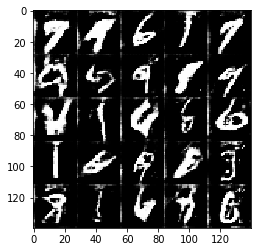

Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 1.7730
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 1.8419... Generator Loss: 0.3911
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 1.9840
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.0803
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.6124
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 2.2361
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.9511


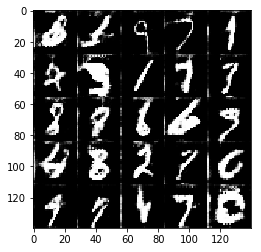

Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 2.4302
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.3845


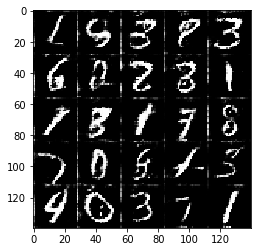

Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.1164
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 1.8862
Epoch 2/2... Discriminator Loss: 1.6969... Generator Loss: 3.5487
Epoch 2/2... Discriminator Loss: 1.6455... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 0.9920
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.7421
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 2.0785
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 1.6637
Epoch 2/2... Discriminator Loss: 0.9779... Generator Loss: 1.2524


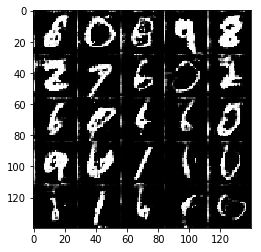

Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 2.0632
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 1.2179
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 1.7521
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 2.3074
Epoch 2/2... Discriminator Loss: 0.7243... Generator Loss: 1.9295
Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.6049
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.5796


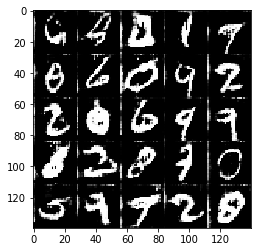

Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 0.5101
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.7315
Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 1.8355
Epoch 2/2... Discriminator Loss: 1.4846... Generator Loss: 3.5814
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.4067
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 1.0437
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.3375


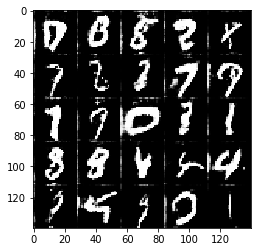

Epoch 2/2... Discriminator Loss: 1.6441... Generator Loss: 0.3994
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 1.9949
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 1.2580
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.4605... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 1.5072... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 1.9803


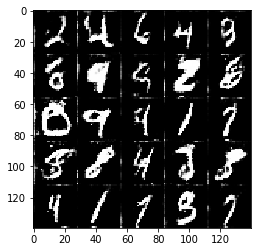

Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 1.0417
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 2.0022
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.5352
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.5518
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.7742
Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 1.8789
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.3606
Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 1.2714
Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 1.7206


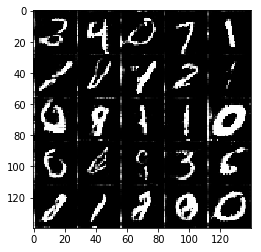

Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.1494... Generator Loss: 1.0836
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 1.0060
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.5880
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.1513
Epoch 2/2... Discriminator Loss: 0.6935... Generator Loss: 1.5046
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 2.3334
Epoch 2/2... Discriminator Loss: 2.1916... Generator Loss: 0.2578


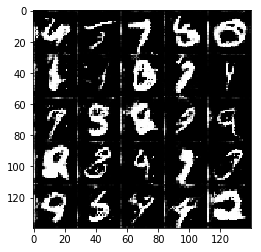

Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.2077
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 0.9657
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 1.1153


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.5016... Generator Loss: 0.0173
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 2.9710
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7139


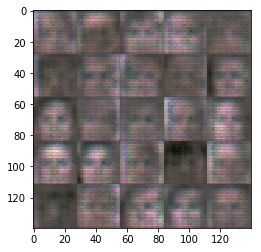

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.8855... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7041


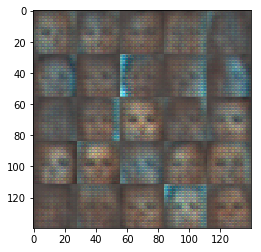

Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.9149


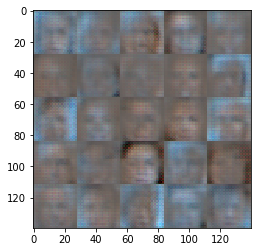

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.6215... Generator Loss: 0.6251


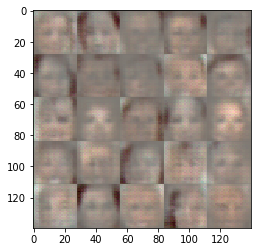

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7427


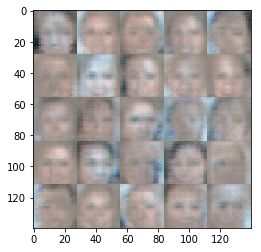

Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7095


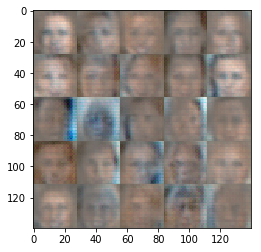

Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.0427


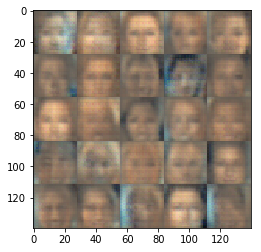

Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.9072


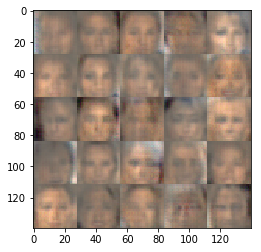

Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.8135


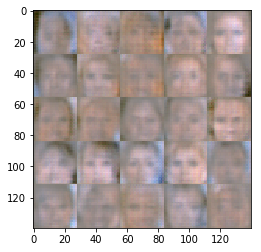

Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6202


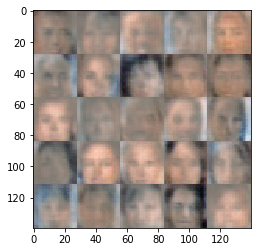

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.6627


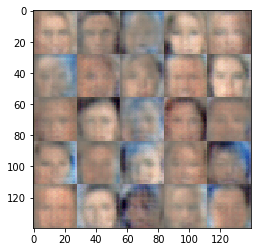

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.8836


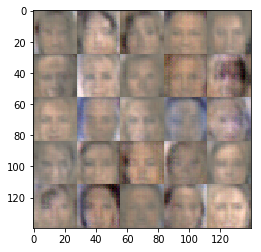

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7268


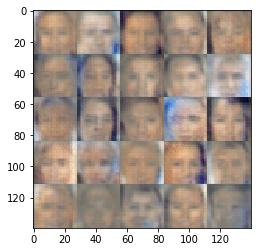

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7575


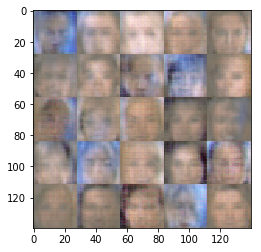

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8009


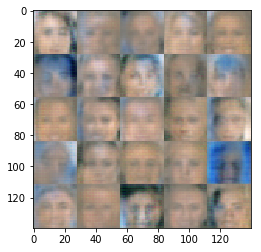

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6984


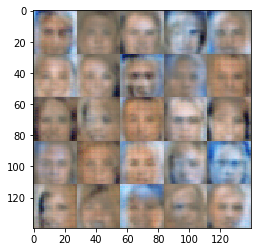

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7331


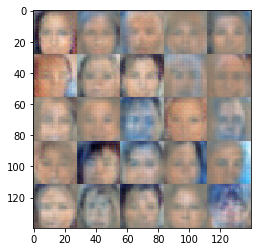

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.9152


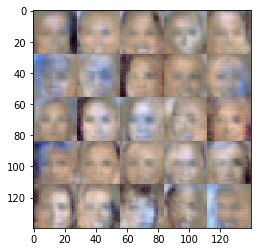

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7239


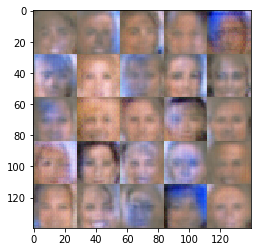

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7887


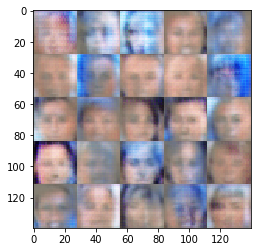

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.9151


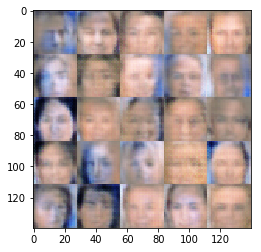

Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7551


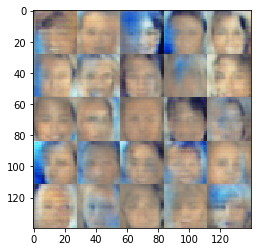

Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.9882


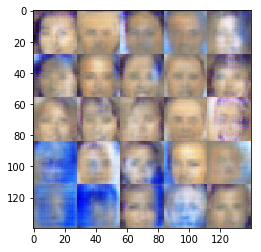

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.6730


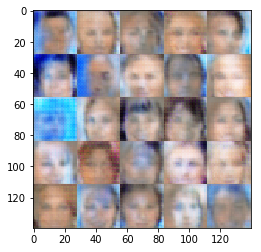

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.9552


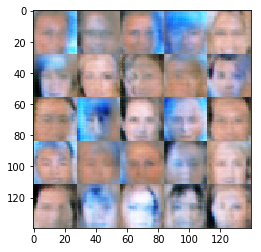

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8162


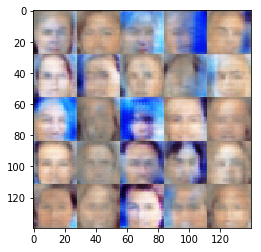

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7396


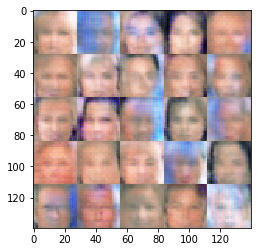

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7621


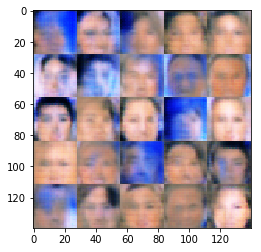

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7318


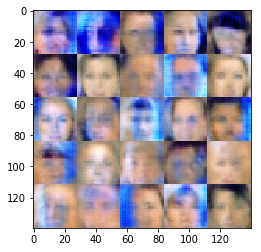

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8440


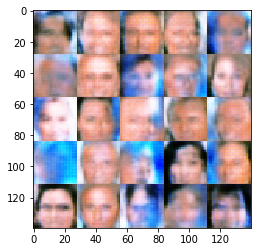

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6908


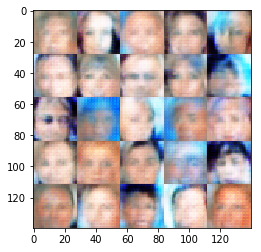

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7702


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.